In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
X_train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
X_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
sample_submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

In [3]:
X_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


Let's check missing data

In [4]:
X_train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Clearly there is a some missing data in each category. We will have to handle it later.

Let's explore expenditures, perhaps it makes sense to create a feature 'Total expenditure'?

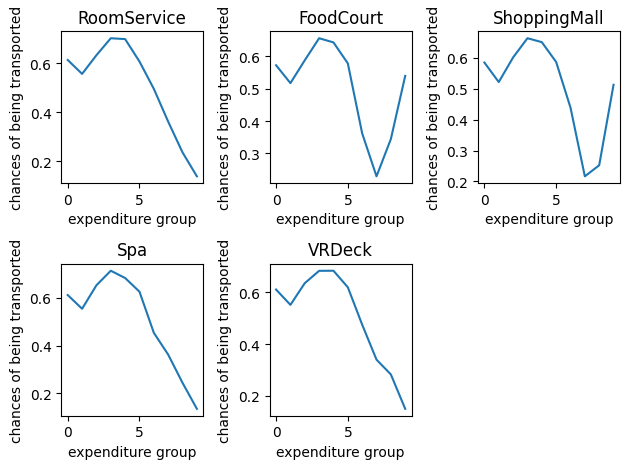

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

rooms = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig = plt.figure()


for i, room in enumerate(rooms):
    X_train[room+'_rank'] = X_train[room].rank(method = 'first')
    X_train[room+'_cut'] = pd.qcut(X_train[room + '_rank'], q = 10, labels = list(range(10)))
    X_train.drop(columns = room +'_rank',inplace=True)
    
    fig.add_subplot(2,3,i+1)
    transport_chances = [len(X_train.loc[(X_train[room+'_cut'] == i) & (X_train['Transported'] == True)])/len(X_train.loc[(X_train[room+'_cut'] == i)]) for i in range(10)]
    plt.plot(transport_chances)
    plt.title(room)
    plt.xlabel('expenditure group')
    plt.ylabel('chances of being transported')
    
    '''for i in range(10):
        print(f'transport chance for room {room} bin {i}',len(X_train.loc[(X_train[room+'_cut'] == i) & (X_train['Transported'] == True)])/len(X_train.loc[(X_train[room+'_cut'] == i)]))'''
    X_train.drop(columns = room+ '_cut',inplace=True)
    
fig.tight_layout()

It is clearly visible that 'RoomSerive', 'Spa' and 'VRDeck' follow roughly the same curve, just as 'FoodCourt' and 'ShoppingMall' do. It is interesting. Let's check correlations.

In [6]:
X_train[rooms].corr()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
RoomService,1.000000,-0.015889,0.054480,0.010080,-0.019581
FoodCourt,-0.015889,1.000000,-0.014228,0.221891,0.227995
ShoppingMall,0.054480,-0.014228,1.000000,0.013879,-0.007322
Spa,0.010080,0.221891,0.013879,1.000000,0.153821
VRDeck,-0.019581,0.227995,-0.007322,0.153821,1.000000


No striking correlation. Perhaps if we sum up variables following the same pattern we will have similiar curves? Let's see, out of curiosoty.

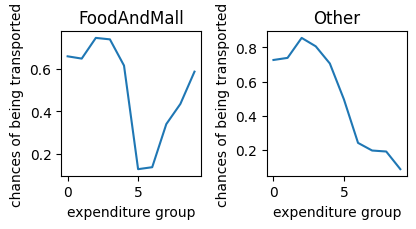

In [7]:
fig = plt.figure(figsize = [6.4*(2/3), 4.8/2])

FoodAndMall = ['FoodCourt', 'ShoppingMall']
Other = ['Spa','VRDeck', 'RoomService']

summed = ['FoodAndMall', 'Other']

X_train['FoodAndMall'] = X_train.loc[:,FoodAndMall].sum(axis = 1)
X_train['Other'] = X_train.loc[:,Other].sum(axis = 1)

for i, room in enumerate(summed):
    X_train[room+'_rank'] = X_train[room].rank(method = 'first')
    X_train[room+'_cut'] = pd.qcut(X_train[room + '_rank'], q = 10, labels = list(range(10)))
    X_train.drop(columns = room +'_rank',inplace=True)
    
    fig.add_subplot(1,2,i+1)
    transport_chances = [len(X_train.loc[(X_train[room+'_cut'] == i) & (X_train['Transported'] == True)])/len(X_train.loc[(X_train[room+'_cut'] == i)]) for i in range(10)]
    plt.plot(transport_chances)
    plt.title(room)
    plt.xlabel('expenditure group')
    plt.ylabel('chances of being transported')
    
    '''for i in range(10):
        print(f'transport chance for room {room} bin {i}',len(X_train.loc[(X_train[room+'_cut'] == i) & (X_train['Transported'] == True)])/len(X_train.loc[(X_train[room+'_cut'] == i)]))'''
    X_train.drop(columns = room+ '_cut',inplace=True)
    
fig.tight_layout()

Let's see the distribution of values

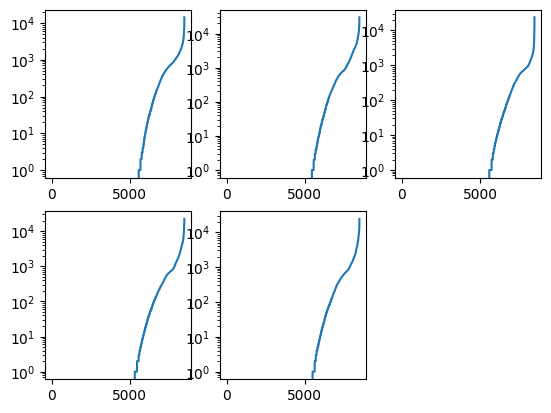

In [8]:
fig = plt.figure()

for i, room in enumerate(rooms):
    expenditure = X_train[[room]].sort_values(by = room).reset_index()
    fig.add_subplot(2,3,i+1)
    plt.yscale('log')
    plt.plot(expenditure.index,expenditure[room])


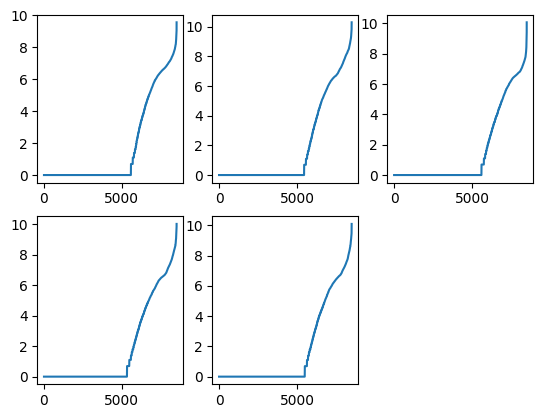

In [9]:
fig = plt.figure()

for i, room in enumerate(rooms):
    expenditure = X_train[[room]].sort_values(by = room).reset_index()
    fig.add_subplot(2,3,i+1)
    plt.plot(expenditure.index,np.log1p(expenditure[room]))

From above it is clear that we need to transform these features with **np.log1p** to get more managable input for the model. We will fill NAs with '**mean**', because graphs point to 'mean' being the most neutral value.
**Correction**: impute to 0, because in crysleep you don't spend

Let's look at '**Destination**'

In [10]:
X_train.Destination.unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

In [11]:
dests = ['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e']

for dest in dests:
    print(len(X_train.loc[(X_train.Destination == dest) & X_train.Transported == True])/len(X_train.loc[X_train.Destination == dest]))
    
print(len(X_train[X_train.Transported == True])/len(X_train))

0.47117497886728654
0.5037688442211056
0.61
0.5036236051995858


**'PSO J318.5-22'** gives 50% chance of being Transported, same as overall chance of being Transported, so let's fill NAs with this.

Now consider the VIP status in similar fashion

In [12]:
for status in [True,False]:
    print(len(X_train.loc[(X_train.VIP == status) & X_train.Transported == True])/len(X_train.loc[X_train.VIP == status]))
    
print(len(X_train[X_train.Transported == True])/len(X_train))

0.38190954773869346
0.5063321674104451
0.5036236051995858


Apparently VIPs are on average too important to be transported from our spaceship, but Non-VIP status does not affect the chance. We will fill NAs from **VIP with False**

Let us consider 'Age'. Perhaps it will be a good idea to split it into some buckets.

In [13]:
print(min(X_train.Age),max(X_train.Age))

0.0 79.0


In [14]:
age_buckets = [0,5,18,80]

for i in range(len(age_buckets) - 1):
    gr = X_train[X_train.Age.between(age_buckets[i],age_buckets[i+1],inclusive = 'left')]
    print(i, len(gr[gr.Transported == True])/len(gr))
    

0 0.7682403433476395
1 0.5699721964782206
2 0.47567800258286697


Looking at Transport chance by **age** we can roughly identify 3 groups: <5, 5-17, 18>= (**[0,5,18,80]**) and we will bucket Age into them. **Mean** age seems to be good value to fill NAs.

Let's look at 'CryoSleep'

In [15]:
for status in [True,False]:
    print(len(X_train.loc[(X_train.CryoSleep == status) & X_train.Transported == True])/len(X_train.loc[X_train.CryoSleep == status]))
    
print(len(X_train[X_train.Transported == True])/len(X_train))

0.8175831412578202
0.3289207574921861
0.5036236051995858


Cryosleep has massive impact on the chance of being Transported. We should either drop rows with NAs or **encode them with zeroes******. Let's do the latter, because test data can also have this column missing.

Let's finally consider 'HomePlanet'

In [16]:
X_train.HomePlanet.unique()

array(['Europa', 'Earth', 'Mars', nan], dtype=object)

In [17]:
homes = ['Europa', 'Earth', 'Mars']

for home in homes:
    print(len(X_train.loc[(X_train.HomePlanet == home) & X_train.Transported == True])/len(X_train.loc[X_train.HomePlanet == home]))
    
print(len(X_train[X_train.Transported == True])/len(X_train))

0.65884561238855
0.42394611038678837
0.5230244457077885
0.5036236051995858


From the above, we will fill '**HomePlanet**' with '**Mars**'

Columns 'PassengerId' and 'Name' require to be examined together as both give as some information about interrelations between the passengers. From surnames we can infer belonging to the same family. Perhaps when many people have same surname, we can split them into families only by knowing, which are in the same group, extracted from PassengerId?

In [18]:
X_train['PassengerGroupId'] = X_train['PassengerId'].str[:4]
X_train['Surname'] = X_train['Name'].str.extract(pat=r' (\w+)$')

In [19]:
X_train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,FoodAndMall,Other,PassengerGroupId,Surname
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,0.0,0001,Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,34.0,702.0,0002,Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3576.0,6807.0,0003,Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,1654.0,3522.0,0003,Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,221.0,870.0,0004,Santantines


In [20]:
X_train.nunique()

PassengerId         8693
HomePlanet             3
CryoSleep              2
Cabin               6560
Destination            3
Age                   80
VIP                    2
RoomService         1273
FoodCourt           1507
ShoppingMall        1115
Spa                 1327
VRDeck              1306
Name                8473
Transported            2
FoodAndMall         1966
Other               2332
PassengerGroupId    6217
Surname             2217
dtype: int64

In [21]:
val_c = X_train['Surname'].value_counts()
len(val_c[val_c>16])

1

In [22]:
val_c2 = X_train['PassengerGroupId'].value_counts()
len(val_c2[val_c2>5])

75

In [23]:
surname_groups = X_train[['Surname','Transported']]
surname_groups['Size'] = surname_groups.groupby(by=['Surname']).transform(lambda x: len(x))

for i in range(2,19):
    bigger_surname_groups = surname_groups[surname_groups['Size'] == i]
    print(bigger_surname_groups.groupby(by=['Surname']).agg(res = ('Transported',lambda x: sum(x == True)/len(x))).mean().values)


/tmp/ipykernel_18/1759128008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surname_groups['Size'] = surname_groups.groupby(by=['Surname']).transform(lambda x: len(x))


[0.49375]
[0.53436426]
[0.50390625]
[0.509375]
[0.49903661]
[0.48139256]
[0.45404412]
[0.48253968]
[0.51]
[0.50545455]
[0.42857143]
[0.46153846]
[0.48214286]
[0.6]
[0.375]
[nan]
[0.38888889]


It would appear that same Surname people aren't targeted...

In [24]:
pass_groups = X_train[['PassengerGroupId','Transported']]
pass_groups['Size'] = pass_groups.groupby(by=['PassengerGroupId']).transform(lambda x: len(x))

for i in range(1,10):
    selected_pass_groups = pass_groups[pass_groups['Size'] == i]
    print(selected_pass_groups.groupby(by=['PassengerGroupId']).agg(res = ('Transported',lambda x: sum(x == True)/len(x))).mean().values)

/tmp/ipykernel_18/1948108172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_groups['Size'] = pass_groups.groupby(by=['PassengerGroupId']).transform(lambda x: len(x))


[0.45244537]
[0.53804994]
[0.59313725]
[0.6407767]
[0.59245283]
[0.61494253]
[0.54112554]
[0.39423077]
[nan]


Bigger groups (3-6) do seem to have bigger chance of Transportation

Now, let's consider family members in groups

In [25]:
groups = X_train[['Surname','PassengerGroupId','Transported']]
groups['Size'] = groups.groupby(by=['Surname','PassengerGroupId']).transform(lambda x: len(x))

print(groups[groups.Size>1].head(5))

for i in range(1,10):
    selected_groups = groups[pass_groups['Size'] == i]
    print(selected_groups.groupby(by=['Surname','PassengerGroupId']).agg(res = ('Transported',lambda x: sum(x == True)/len(x))).mean().values)

/tmp/ipykernel_18/83698122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  groups['Size'] = groups.groupby(by=['Surname','PassengerGroupId']).transform(lambda x: len(x))


       Surname PassengerGroupId  Transported  Size
2       Susent             0003        False   2.0
3       Susent             0003        False   2.0
6  Jacostaffey             0006         True   2.0
7  Jacostaffey             0006         True   2.0
9       Flatic             0008         True   3.0
[0.45245692]
[0.53837597]
[0.60119048]
[0.62183908]
[0.60654762]
[0.60333333]
[0.56857143]
[0.36152211]
[nan]


From the above it appears that 'number of people with same surname sharing the same group' is the important feature.  We can guess that people with the same surname in the same group are family members and apparently there is a bigger chance of multiple getting transported. For this reason we need to create a **feature encoding number of family members on board**. We could perhaps try to create bins like 'between 2 and 5 family members', but let's stay with just a number.
Let's **fill NAs with '2'** as this number is closest to average.

The last feature to analyze is 'Cabin' and this one will also require feature extraction.

In [26]:
decks = X_train['Cabin'].str.extract(pat='^(.+?)/')
X_train['Deck'] = decks
decks.iloc[:,0].unique()

array(['B', 'F', 'A', 'G', nan, 'E', 'D', 'C', 'T'], dtype=object)

In [27]:
nums = X_train['Cabin'].str.extract(pat='^[^/]*?/(.+?)/').astype('float64')
X_train['CabinNumber'] = nums
nums.iloc[:,0].unique()

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.892e+03, 1.893e+03,
       1.894e+03])

In [28]:
sides = X_train['Cabin'].str.extract(pat='/([^/]*)$')
X_train['ShipSide'] = sides
sides.iloc[:,0].unique()

array(['P', 'S', nan], dtype=object)

In [29]:
decks = ['B', 'F', 'A', 'G', 'E', 'D', 'C', 'T']
side = ['P', 'S']

In [30]:
grouped = X_train.groupby(by=['ShipSide','Deck'])
print(grouped.agg(min_cabin_num = ('CabinNumber', min),max_cabin_num = ('CabinNumber', max)))


               min_cabin_num  max_cabin_num
ShipSide Deck                              
P        A               0.0           98.0
         B               0.0          301.0
         C               0.0          309.0
         D               0.0          295.0
         E               5.0          597.0
         F               0.0         1894.0
         G               0.0         1508.0
         T               0.0            3.0
S        A               0.0          107.0
         B               1.0          353.0
         C               2.0          342.0
         D               1.0          276.0
         E               0.0          608.0
         F               0.0         1793.0
         G               0.0         1500.0
         T               2.0            2.0


/tmp/ipykernel_18/3791180699.py:2: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  print(grouped.agg(min_cabin_num = ('CabinNumber', min),max_cabin_num = ('CabinNumber', max)))
/tmp/ipykernel_18/3791180699.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  print(grouped.agg(min_cabin_num = ('CabinNumber', min),max_cabin_num = ('CabinNumber', max)))


Decks 'F' and 'G' are much bigger then others. Let's bin them by hundreds. Standard decks are perhaps to small to subdivide them further. Deck T is extremely small, too small to use it for prediction. We should refrain from encoding it.

               chance_is_transported
ShipSide Deck                       
P        A                  0.435897
         B                  0.674221
         C                  0.580645
         D                  0.403226
         E                  0.342657
         T                  0.250000
S        A                  0.546763
         B                  0.784038
         C                  0.763547
         D                  0.465217
         E                  0.371365
         T                  0.000000


<Axes: xlabel='Deck'>

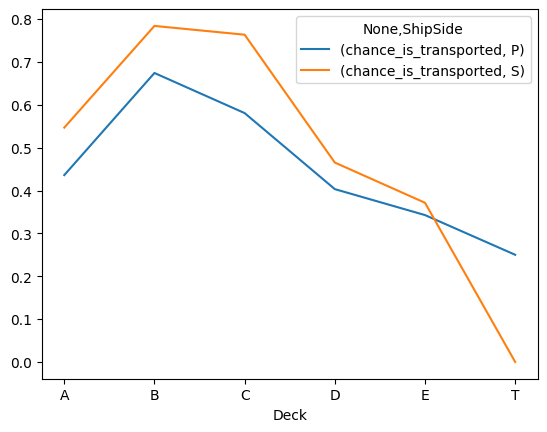

In [31]:
small_decks = ['B', 'A', 'E', 'D', 'C','T']
big_decks = ['F','G']

small_grouped = X_train[X_train['Deck'].isin(small_decks)].groupby(['ShipSide','Deck'])
small_grouped = small_grouped.agg(chance_is_transported = ('Transported',lambda x: sum(x)/len(x)))
print(small_grouped)
small_grouped.unstack(level=0).plot()

/tmp/ipykernel_18/2467925667.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_decks_df['CabinNumber'] = small_decks_df['CabinNumber'].astype('int64')
/tmp/ipykernel_18/2467925667.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_decks_df['CabinNumberBinned'] = pd.cut(small_decks_df['CabinNumber'], bins = num_bins, labels = list(range(0,600,100)), include_lowest = True )
/tmp/ipykernel_18/2467925667.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True 

<Axes: xlabel='CabinNumberBinned'>

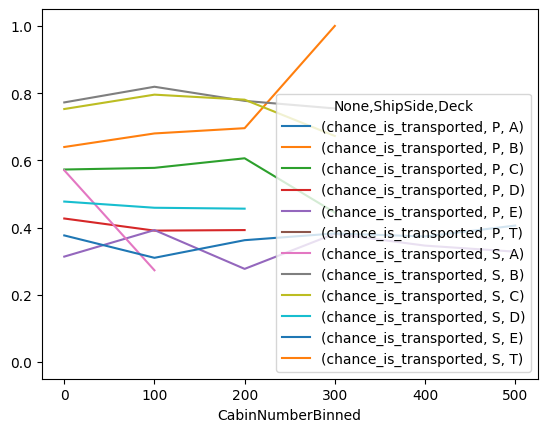

In [32]:
small_decks_df = X_train[X_train['Deck'].isin(small_decks)]
small_decks_df.dropna(subset = 'CabinNumber')
small_decks_df['CabinNumber'] = small_decks_df['CabinNumber'].astype('int64')
num_bins = [100*i for i in range(7)]
small_decks_df['CabinNumberBinned'] = pd.cut(small_decks_df['CabinNumber'], bins = num_bins, labels = list(range(0,600,100)), include_lowest = True )

small_decks_grouped = small_decks_df.groupby(['ShipSide','Deck','CabinNumberBinned'])
small_decks_grouped = small_decks_grouped.agg(chance_is_transported = ('Transported',lambda x: sum(x)/len(x)))
#print(big_decks_grouped)
small_decks_grouped.unstack(level=[0,1]).plot()

Starboard gives bigger chance of getting Transported, Decks have a visible effect too. As for number it doesn't seem to play role.

/tmp/ipykernel_18/3052370570.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_decks_df['CabinNumber'] = big_decks_df['CabinNumber'].astype('int64')
/tmp/ipykernel_18/3052370570.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_decks_df['CabinNumberBinned'] = pd.cut(big_decks_df['CabinNumber'], bins = num_bins, labels = list(range(0,1900,100)), include_lowest = True )
/tmp/ipykernel_18/3052370570.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fu

<Axes: xlabel='CabinNumberBinned'>

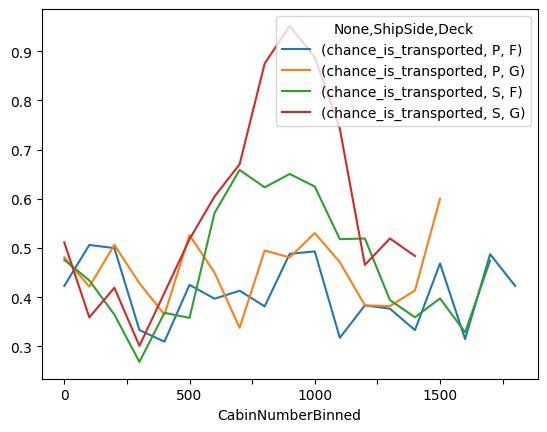

In [33]:
big_decks_df = X_train[X_train['Deck'].isin(big_decks)]
big_decks_df.dropna(subset = 'CabinNumber')
big_decks_df['CabinNumber'] = big_decks_df['CabinNumber'].astype('int64')
num_bins = [100*i for i in range(20)]
big_decks_df['CabinNumberBinned'] = pd.cut(big_decks_df['CabinNumber'], bins = num_bins, labels = list(range(0,1900,100)), include_lowest = True )

big_decks_grouped = big_decks_df.groupby(['ShipSide','Deck','CabinNumberBinned'])
big_decks_grouped = big_decks_grouped.agg(chance_is_transported = ('Transported',lambda x: sum(x)/len(x)))
#print(big_decks_grouped)
big_decks_grouped.unstack(level=[0,1]).plot()


Pattern for Port side seems to exhibit no connection with Cabin number. Starboard side on the other hand does seem to. We will **preserve bins for Starboard, but not for Port side.**
Imputing **NA's** seems impossible, so we will simply **ignore them**.

Now we have to finally construct the model. First we need to build a Pipeline.

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

from category_encoders import TargetEncoder

from sklearn import set_config
set_config(transform_output = "pandas")


In [35]:
amenities_imputer = SimpleImputer(strategy = 'constant', fill_value = 0).set_output(transform="pandas")
amenities_log1p = FunctionTransformer(np.log1p)
amenities_scaler = StandardScaler()

destination_imputer = SimpleImputer(strategy = 'constant', fill_value='PSO J318.5-22').set_output(transform="pandas")

vip_imputer = SimpleImputer(strategy = 'constant', fill_value=False).set_output(transform="pandas")

age_imputer = SimpleImputer(strategy = 'mean').set_output(transform="pandas")

def bucketer(df):
    df['AgeBinned'] = pd.cut(df['Age'],bins = [0,5,18,80], labels = ['5_or_less', '5-17', '18_or_more'],include_lowest = True)
    return df[['AgeBinned']]
age_to_buckets = FunctionTransformer(bucketer).set_output(transform="pandas")

home_planet_imputer = SimpleImputer(strategy = 'constant', fill_value='Mars').set_output(transform="pandas")

family_imputer = SimpleImputer(strategy = 'constant', fill_value='2').set_output(transform="pandas")
def family_size(df):
    df['PassengerGroupId'] = df['PassengerId'].str[:4]
    df['Surname'] =df['Name'].str.extract(pat=r' (\w+)$')
    df = df[['PassengerGroupId','Surname']]
    df['placeholder'] = 1
    df['Family_Size'] = df.groupby(by=['Surname','PassengerGroupId']).transform(lambda x: len(x))
    return df[['Family_Size']]
family_size_creator =  FunctionTransformer(family_size).set_output(transform="pandas")

def cabin_encoder(df):
    small_decks = ['B', 'A', 'E', 'D', 'C']
    df['Deck'] = df['Cabin'].str.extract(pat='^(.+?)/')  
    df['CabinNumber'] = df['Cabin'].str.extract(pat='^[^/]*?/(.+?)/').astype('float64')
    df['ShipSide'] = df['Cabin'].str.extract(pat='/([^/]*)$')
    df['Cabin_encoded'] = df['Cabin']
    df.loc[df['Deck'].isin(small_decks),'Cabin_encoded'] = df.loc[df['Deck'].isin(small_decks),'Deck'] + df.loc[df['Deck'].isin(small_decks),'ShipSide']
    
    big_decks = ['F', 'G']
    num_bins = [250*i for i in range(8)]
    df['CabinBins'] = 0
    df.loc[df['Deck'].isin(big_decks),'CabinBins'] = pd.cut(df.loc[df['Deck'].isin(big_decks),'CabinNumber'], bins = num_bins, labels = [str(250*i) for i in range(1,8)], include_lowest=True)
    df.loc[df['Deck'].isin(big_decks),'Cabin_encoded'] = df.loc[df['Deck'].isin(big_decks),'Deck'] + df.loc[df['Deck'].isin(big_decks),'ShipSide'] + df.loc[df['Deck'].isin(big_decks),'CabinBins']
    
    df.loc[(df['Deck'].isin(big_decks)) & (df['ShipSide'] == 'P'),'Cabin_encoded'] = df.loc[(df['Deck'].isin(big_decks)) & (df['ShipSide'] == 'P'),'Deck'] + df.loc[(df['Deck'].isin(big_decks)) & (df['ShipSide'] == 'P'),'ShipSide']
    
    
    df.loc[df['Deck'] == 'T', 'Cabin_encoded'] = np.nan

    return df[['Cabin_encoded']]

cabin_creator = FunctionTransformer(cabin_encoder).set_output(transform="pandas")

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [36]:
amenities_tranformer = Pipeline([('amenities_imputer', amenities_imputer),('amenities_log1p', amenities_log1p),('amenities_scaler',amenities_scaler)])
destination_transformer = Pipeline([('destination_imputer', destination_imputer),('destination_encoder', OneHotEncoder(sparse=False).set_output(transform="pandas"))])
vip_transformer =  Pipeline([('vip_imputer', vip_imputer),('vip_encoder', OneHotEncoder(sparse=False).set_output(transform="pandas"))])
age_transformer = Pipeline([('age_imputer', age_imputer),('age_to_buckets', age_to_buckets),('age_encoder', OneHotEncoder(sparse=False).set_output(transform="pandas"))])
home_planet_transformer = Pipeline([('home_planet_imputer', home_planet_imputer),('home_planet_encoder', OneHotEncoder(sparse=False).set_output(transform="pandas"))])
cryo_transformer = Pipeline([('cryo_encoder',OneHotEncoder(handle_unknown = 'ignore',sparse_output = False))])
family_transformer = Pipeline([('family_imputer',family_imputer),('family_size_creator',family_size_creator)])
#cabin_transformer = Pipeline([('cabin_creator',cabin_creator),('cabin_encoder',(TargetEncoder().set_output(transform="pandas")))])
cabin_transformer = Pipeline([('cabin_creator',cabin_creator),('cabin_encoder',OneHotEncoder(handle_unknown = 'ignore',sparse_output = False))])

In [37]:
rooms = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

transforms_composed = ColumnTransformer([('amenities_tranformer',amenities_tranformer,rooms),
                                        ('destination_transformer',destination_transformer,['Destination']),
                                        ('vip_transformer',vip_transformer,['VIP']),
                                        ('age_transformer',age_transformer,['Age']),
                                        ('home_planet_transformer',home_planet_transformer,['HomePlanet']),
                                        ('cryo_transformer',cryo_transformer,['CryoSleep']),
                                        ('family_transformer',family_transformer,['PassengerId','Name']),
                                        ('cabin_transformer',cabin_transformer,['Cabin'])])


Now let's optimize our model. We will do it step-wise. First we will set some relatively high learning rate and optimize n_estimators for it.

In [38]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

y_train = X_train['Transported']

In [39]:
'''n_estimators_t = [500 + 250*i for i in range(5)]

for n_estimators in n_estimators_t:
    model = XGBClassifier(n_estimators = n_estimators, learning_rate = 0.05)
    my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])
    scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')
    print(f'scores for n_estimators = {n_estimators}', scores, f'mean scores: {scores.mean()}')'''
    

"n_estimators_t = [500 + 250*i for i in range(5)]\n\nfor n_estimators in n_estimators_t:\n    model = XGBClassifier(n_estimators = n_estimators, learning_rate = 0.05)\n    my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])\n    scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')\n    print(f'scores for n_estimators = {n_estimators}', scores, f'mean scores: {scores.mean()}')"

After itterative narrowing down, we find that 85 gives best results and move on to the max_depth and min_child_weight

In [40]:
'''max_depths = [4,5,6,7,8]
min_child_weights = [0.5,1,2,3,4]

for max_depth in max_depths:
    for min_child_weight in min_child_weights:
        model = XGBClassifier(n_estimators = 85, learning_rate = 0.05, max_depth = max_depth, min_child_weight=min_child_weight)
        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])
        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')
        print(f'scores for max_depth = {max_depth} and min_child_weights = {min_child_weight}', scores, f'mean score: {scores.mean()}')'''
        

"max_depths = [4,5,6,7,8]\nmin_child_weights = [0.5,1,2,3,4]\n\nfor max_depth in max_depths:\n    for min_child_weight in min_child_weights:\n        model = XGBClassifier(n_estimators = 85, learning_rate = 0.05, max_depth = max_depth, min_child_weight=min_child_weight)\n        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])\n        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')\n        print(f'scores for max_depth = {max_depth} and min_child_weights = {min_child_weight}', scores, f'mean score: {scores.mean()}')"

In [41]:
'''max_depths = [3,4,5,6,7,8]
min_child_weights = [5,6,7,8]

for max_depth in max_depths:
    for min_child_weight in min_child_weights:
        model = XGBClassifier(n_estimators = 85, learning_rate = 0.05, max_depth = max_depth, min_child_weight=min_child_weight)
        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])
        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')
        print(f'scores for max_depth = {max_depth} and min_child_weights = {min_child_weight}', scores, f'mean score: {scores.mean()}')'''
        

"max_depths = [3,4,5,6,7,8]\nmin_child_weights = [5,6,7,8]\n\nfor max_depth in max_depths:\n    for min_child_weight in min_child_weights:\n        model = XGBClassifier(n_estimators = 85, learning_rate = 0.05, max_depth = max_depth, min_child_weight=min_child_weight)\n        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])\n        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')\n        print(f'scores for max_depth = {max_depth} and min_child_weights = {min_child_weight}', scores, f'mean score: {scores.mean()}')"

In [42]:
'''max_depths = [8,9,10]
min_child_weights = [9,10,11,12]

for max_depth in max_depths:
    for min_child_weight in min_child_weights:
        model = XGBClassifier(n_estimators = 85, learning_rate = 0.05, max_depth = max_depth, min_child_weight=min_child_weight)
        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])
        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')
        print(f'scores for max_depth = {max_depth} and min_child_weights = {min_child_weight}', scores, f'mean score: {scores.mean()}')'''

"max_depths = [8,9,10]\nmin_child_weights = [9,10,11,12]\n\nfor max_depth in max_depths:\n    for min_child_weight in min_child_weights:\n        model = XGBClassifier(n_estimators = 85, learning_rate = 0.05, max_depth = max_depth, min_child_weight=min_child_weight)\n        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])\n        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')\n        print(f'scores for max_depth = {max_depth} and min_child_weights = {min_child_weight}', scores, f'mean score: {scores.mean()}')"

The best results are in this range:
* scores for max_depth = 6 and min_child_weights = 5 [0.78723404 0.79758482 0.79700978 0.82508631 0.80552359] mean score: 0.8024877067160935
* scores for max_depth = 6 and min_child_weights = 6 [0.78493387 0.79873491 0.80103508 0.82278481 0.80379747] mean score: 0.8022572262539944
* scores for max_depth = 6 and min_child_weights = 7 [0.78550891 0.79700978 0.79873491 0.82566168 0.80494822] mean score: 0.8023726980904465
* scores for max_depth = 6 and min_child_weights = 8 [0.78780909 0.79585969 0.80046003 0.81530495 0.80437284] mean score: 0.8007613200449182
* scores for max_depth = 7 and min_child_weights = 5 [0.786659   0.79528465 0.79873491 0.82681243 0.80609896] mean score: 0.802717988659276
* scores for max_depth = 7 and min_child_weights = 6 [0.79010926 0.79183439 0.79988499 0.8273878  0.80149597] mean score: 0.8021424823202363
* scores for max_depth = 7 and min_child_weights = 7 [0.79183439 0.79585969 0.80391029 0.82220944 0.80379747] mean score: 0.8035222549631383
* scores for max_depth = 7 and min_child_weights = 8 [0.79413456 0.79700978 0.80103508 0.81357883 0.80149597] mean score: 0.8014508424150222
* scores for max_depth = 8 and min_child_weights = 5 [0.78895917 0.79700978 0.80046003 0.82853855 0.7986191 ] mean score: 0.8027173269295542
* scores for max_depth = 8 and min_child_weights = 6 [0.786659   0.79355952 0.79988499 0.83256617 0.7986191 ] mean score: 0.8022577556377719
* scores for max_depth = 8 and min_child_weights = 7 [0.79355952 0.79700978 0.80046003 0.83141542 0.80207135] mean score: 0.8049032187195397
* scores for max_depth = 8 and min_child_weights = 8 [0.79183439 0.79643473 0.80333525 0.81933257 0.80034522] mean score: 0.8022564321783282
 
Let's pick max_depth = 8, min_child_weights = 7

Now let's adjust gamma

In [43]:
'''gammas = [0.0,0.1,0.2,0.3,0.4]

for gamma in gammas:
    model = XGBClassifier(n_estimators = 85, learning_rate = 0.05, max_depth = 8, min_child_weight = 7, gamma = gamma)
    my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])
    scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')
    print(f'scores for gamma = {gamma}', scores, f'mean score: {scores.mean()}')'''

"gammas = [0.0,0.1,0.2,0.3,0.4]\n\nfor gamma in gammas:\n    model = XGBClassifier(n_estimators = 85, learning_rate = 0.05, max_depth = 8, min_child_weight = 7, gamma = gamma)\n    my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])\n    scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')\n    print(f'scores for gamma = {gamma}', scores, f'mean score: {scores.mean()}')"

Gamma 0.2 gives slightly better result.

Now let's do subsample and colsample_bytree

In [44]:
'''subsamples = [0.5,0.6,0.7,0.8,0.9,1.0]
colsample_bytrees = [0.5,0.6,0.7,0.8,0.9,1.0]

for subsample in subsamples:
    for colsample_bytree in colsample_bytrees:
        model = XGBClassifier(n_estimators = 85, learning_rate = 0.05, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = subsample, colsample_bytree = colsample_bytree)
        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])
        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')
        print(f'scores for subsample = {subsample} and colsample_bytree = {colsample_bytree}', scores, f'mean score: {scores.mean()}')
        '''

"subsamples = [0.5,0.6,0.7,0.8,0.9,1.0]\ncolsample_bytrees = [0.5,0.6,0.7,0.8,0.9,1.0]\n\nfor subsample in subsamples:\n    for colsample_bytree in colsample_bytrees:\n        model = XGBClassifier(n_estimators = 85, learning_rate = 0.05, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = subsample, colsample_bytree = colsample_bytree)\n        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])\n        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')\n        print(f'scores for subsample = {subsample} and colsample_bytree = {colsample_bytree}', scores, f'mean score: {scores.mean()}')\n        "

subsample = 0.5, colsample_bytree = 1 seems good.

Now finally, go back to learning_rate and n_estimators.

In [45]:
'''n_estimators_t = [85,95,105,115]
learning_rates = [0.02,0.03,0.04,0.05]

for n_estimators in n_estimators_t:
    for learning_rate in learning_rates:
        model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = 0.5, colsample_bytree = 1)
        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])
        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')
        print(f'scores for n_estimators = {n_estimators} and learning_rate = {learning_rate}', scores, f'mean score: {scores.mean()}')
        '''

"n_estimators_t = [85,95,105,115]\nlearning_rates = [0.02,0.03,0.04,0.05]\n\nfor n_estimators in n_estimators_t:\n    for learning_rate in learning_rates:\n        model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = 0.5, colsample_bytree = 1)\n        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])\n        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')\n        print(f'scores for n_estimators = {n_estimators} and learning_rate = {learning_rate}', scores, f'mean score: {scores.mean()}')\n        "

In [46]:
'''n_estimators_t = [125,135,145]
learning_rates = [0.05]

for n_estimators in n_estimators_t:
    for learning_rate in learning_rates:
        model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = 0.5, colsample_bytree = 1)
        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])
        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')
        print(f'scores for n_estimators = {n_estimators} and learning_rate = {learning_rate}', scores, f'mean score: {scores.mean()}')
        '''

"n_estimators_t = [125,135,145]\nlearning_rates = [0.05]\n\nfor n_estimators in n_estimators_t:\n    for learning_rate in learning_rates:\n        model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = 0.5, colsample_bytree = 1)\n        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])\n        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')\n        print(f'scores for n_estimators = {n_estimators} and learning_rate = {learning_rate}', scores, f'mean score: {scores.mean()}')\n        "

In [47]:
'''pairs = [(125,0.04),(150,0.03),(175,0.02)]

for n_estimators, learning_rate in pairs:
    model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = 0.5, colsample_bytree = 1)
    my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])
    scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')
    print(f'scores for n_estimators = {n_estimators} and learning_rate = {learning_rate}', scores, f'mean score: {scores.mean()}')
'''

"pairs = [(125,0.04),(150,0.03),(175,0.02)]\n\nfor n_estimators, learning_rate in pairs:\n    model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = 0.5, colsample_bytree = 1)\n    my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])\n    scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')\n    print(f'scores for n_estimators = {n_estimators} and learning_rate = {learning_rate}', scores, f'mean score: {scores.mean()}')\n"

In [48]:
'''pairs = [(135,0.04),(175,0.03),(225,0.02)]

for n_estimators, learning_rate in pairs:
    model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = 0.5, colsample_bytree = 1)
    my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])
    scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')
    print(f'scores for n_estimators = {n_estimators} and learning_rate = {learning_rate}', scores, f'mean score: {scores.mean()}')
'''

"pairs = [(135,0.04),(175,0.03),(225,0.02)]\n\nfor n_estimators, learning_rate in pairs:\n    model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = 0.5, colsample_bytree = 1)\n    my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])\n    scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')\n    print(f'scores for n_estimators = {n_estimators} and learning_rate = {learning_rate}', scores, f'mean score: {scores.mean()}')\n"

In [49]:
'''pairs = [(175,0.04),(225,0.03),(300,0.02)]

for n_estimators, learning_rate in pairs:
    model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = 0.5, colsample_bytree = 1)
    my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])
    scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')
    print(f'scores for n_estimators = {n_estimators} and learning_rate = {learning_rate}', scores, f'mean score: {scores.mean()}')
'''

"pairs = [(175,0.04),(225,0.03),(300,0.02)]\n\nfor n_estimators, learning_rate in pairs:\n    model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = 0.5, colsample_bytree = 1)\n    my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])\n    scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')\n    print(f'scores for n_estimators = {n_estimators} and learning_rate = {learning_rate}', scores, f'mean score: {scores.mean()}')\n"

In [50]:
'''n_estimators_t = [135,145,155]
learning_rates = [0.04]

for n_estimators in n_estimators_t:
    for learning_rate in learning_rates:
        model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = 0.5, colsample_bytree = 1)
        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])
        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')
        print(f'scores for n_estimators = {n_estimators} and learning_rate = {learning_rate}', scores, f'mean score: {scores.mean()}')
        '''

"n_estimators_t = [135,145,155]\nlearning_rates = [0.04]\n\nfor n_estimators in n_estimators_t:\n    for learning_rate in learning_rates:\n        model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = 0.5, colsample_bytree = 1)\n        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])\n        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')\n        print(f'scores for n_estimators = {n_estimators} and learning_rate = {learning_rate}', scores, f'mean score: {scores.mean()}')\n        "

In [51]:
'''n_estimators_t = [185,195,215]
learning_rates = [0.03]

for n_estimators in n_estimators_t:
    for learning_rate in learning_rates:
        model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = 0.5, colsample_bytree = 1)
        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])
        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')
        print(f'scores for n_estimators = {n_estimators} and learning_rate = {learning_rate}', scores, f'mean score: {scores.mean()}')
        '''

"n_estimators_t = [185,195,215]\nlearning_rates = [0.03]\n\nfor n_estimators in n_estimators_t:\n    for learning_rate in learning_rates:\n        model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = 0.5, colsample_bytree = 1)\n        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])\n        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')\n        print(f'scores for n_estimators = {n_estimators} and learning_rate = {learning_rate}', scores, f'mean score: {scores.mean()}')\n        "

In [52]:
'''n_estimators_t = [160,165,170]
learning_rates = [0.03]

for n_estimators in n_estimators_t:
    for learning_rate in learning_rates:
        model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = 0.5, colsample_bytree = 1)
        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])
        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')
        print(f'scores for n_estimators = {n_estimators} and learning_rate = {learning_rate}', scores, f'mean score: {scores.mean()}')
        '''

"n_estimators_t = [160,165,170]\nlearning_rates = [0.03]\n\nfor n_estimators in n_estimators_t:\n    for learning_rate in learning_rates:\n        model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = 0.5, colsample_bytree = 1)\n        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])\n        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')\n        print(f'scores for n_estimators = {n_estimators} and learning_rate = {learning_rate}', scores, f'mean score: {scores.mean()}')\n        "

Let's see learning rate 0.05 and some a bit bigger trees than 105

In [53]:
'''n_estimators_t = [108,111,114,117]
learning_rates = [0.05]

for n_estimators in n_estimators_t:
    for learning_rate in learning_rates:
        model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = 0.5, colsample_bytree = 1)
        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])
        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')
        print(f'scores for n_estimators = {n_estimators} and learning_rate = {learning_rate}', scores, f'mean score: {scores.mean()}')
        '''

"n_estimators_t = [108,111,114,117]\nlearning_rates = [0.05]\n\nfor n_estimators in n_estimators_t:\n    for learning_rate in learning_rates:\n        model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = 0.5, colsample_bytree = 1)\n        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])\n        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')\n        print(f'scores for n_estimators = {n_estimators} and learning_rate = {learning_rate}', scores, f'mean score: {scores.mean()}')\n        "

and smaller:

In [54]:
'''n_estimators_t = [400]
learning_rates = [0.05]

for n_estimators in n_estimators_t:
    for learning_rate in learning_rates:
        model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = 0.5, colsample_bytree = 1)
        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])
        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')
        print(f'scores for n_estimators = {n_estimators} and learning_rate = {learning_rate}', scores, f'mean score: {scores.mean()}')'''
        

"n_estimators_t = [400]\nlearning_rates = [0.05]\n\nfor n_estimators in n_estimators_t:\n    for learning_rate in learning_rates:\n        model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = 8, min_child_weight=7, gamma = 0.2, subsample = 0.5, colsample_bytree = 1)\n        my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])\n        scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')\n        print(f'scores for n_estimators = {n_estimators} and learning_rate = {learning_rate}', scores, f'mean score: {scores.mean()}')"

n_estimators = 103, learning_rate = 0.05 turned out best

Let's try using Optuna. 

In [55]:
import optuna

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators',100,1000)
    learning_rate = trial.suggest_float('learning_rate',0.01,0.5)
    max_depth = trial.suggest_int('max_depth',4,10)
    min_child_weight = trial.suggest_float('min_child_weight',1,100)
    gamma = trial.suggest_float('gamma', 0, 0.5)
    subsample = trial.suggest_float('subsample',0.2,1)
    colsample_bytree = trial.suggest_float('colsample_bytree',0.5,1)
    
    model = XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth = max_depth, min_child_weight=min_child_weight, \
                          gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree)
    my_pipeline = Pipeline([('transformer',transforms_composed),('model', model)])
    scores = cross_val_score(my_pipeline,X_train,y_train,cv=5,scoring='accuracy')
    
    return scores.mean()
    

In [56]:
'''study = optuna.create_study(study_name = 'SpaceshipTitani_study1',sampler = optuna.samplers.TPESampler(), direction = 'maximize')'''

"study = optuna.create_study(study_name = 'SpaceshipTitani_study1',sampler = optuna.samplers.TPESampler(), direction = 'maximize')"

In [57]:
'''study.optimize(objective, n_trials = 100)'''

'study.optimize(objective, n_trials = 100)'

In [58]:
'''study.best_trial
study.best_params'''

'study.best_trial\nstudy.best_params'

In [59]:
'''study.best_value'''

'study.best_value'

{'n_estimators': 395,
 'learning_rate': 0.01769507617632657,
 'max_depth': 5,
 'min_child_weight': 9.434016020871315,
 'gamma': 0.11430656416343789,
 'subsample': 0.47154109449604587,
 'colsample_bytree': 0.7662892488549456}
 0.8067445478433898

best for version with one-hot encoded cabins:
{'n_estimators': 311,
 'learning_rate': 0.04193975399628737,
 'max_depth': 4,
 'min_child_weight': 4.130900483127343,
 'gamma': 0.1968817566967786,
 'subsample': 0.7542444088957558,
 'colsample_bytree': 0.9186893098410408}
 study.best_value

In [60]:
final_model = XGBClassifier(n_estimators = 311, learning_rate = 0.04193975399628737, max_depth = 4, min_child_weight=4.130900483127343, gamma = 0.1968817566967786, subsample = 0.7542444088957558, colsample_bytree = 0.9186893098410408)
final_pipeline = Pipeline([('transformer',transforms_composed),('model', final_model)])

final_pipeline.fit(X_train,y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('amenities_tranformer',
                                                  Pipeline(steps=[('amenities_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('amenities_log1p',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('amenities_scaler',
                                                                   StandardScaler())]),
                                                  ['RoomService', 'FoodCourt',
                                                   'ShoppingMall', 'Spa',
                                                   'VRDeck']),
                                                 ('destination_tra...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.04193975399628737, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None,
                               min_child_weight=4.130900483127343, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=311, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [61]:
trs = transforms_composed.fit_transform(X_train,y_train)

<Axes: >

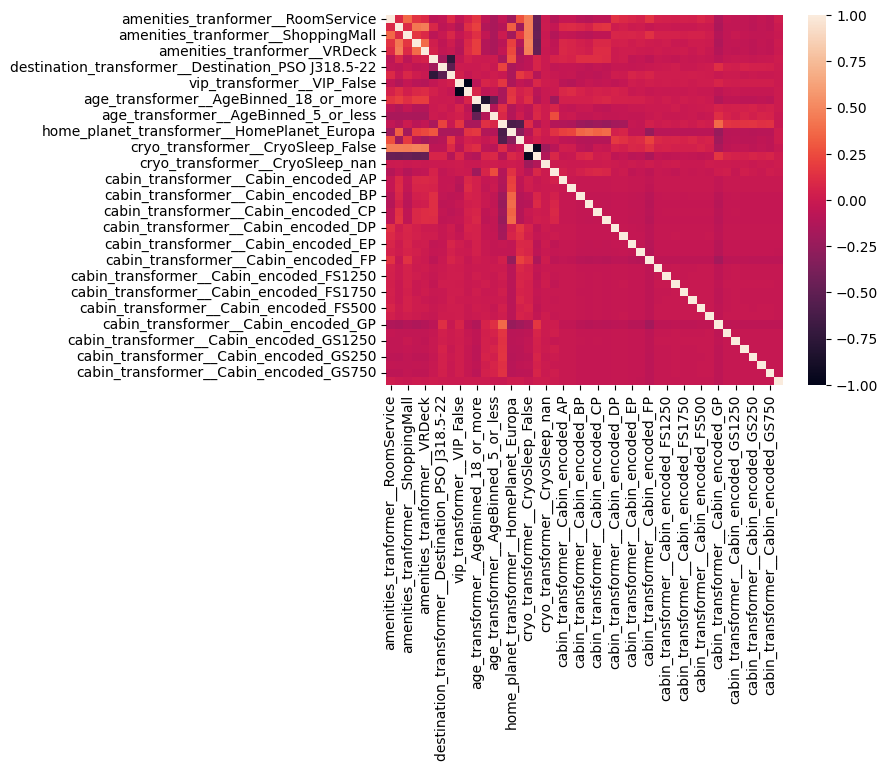

In [62]:
trs.columns
trs.head(5)
import seaborn as sns
sns.heatmap(trs.corr())

In [63]:
predictions = final_pipeline.predict(X_test)
X_test['Transported'] = predictions
predictions_df = X_test[['PassengerId', 'Transported']]
predictions_df['Transported'] = predictions_df['Transported'].map(lambda x: True if x == 1 else False)
predictions_df
#predictions_df.set_index('PassengerId')

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [64]:
predictions_df.to_csv('submission.csv', index=False)